In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from functools import partial
from tqdm import tqdm

# can't get tqdm.notebook to work, this also works
tqdm = partial(tqdm, position=0, ncols=100)

### Efficient loading of reviews

In [4]:
REVIEW_DATA_CASTS = {
    "beer_id": int, "brewery_id": int, "date": int,
    "abv": float, "appearance": float, "aroma": float, "palate": float,
    "taste": float, "overall": float, "rating": float,
    "review": lambda x: True if x == "True" else False
}

FILE_RATINGS = {
    "BeerAdvocate/reviews.txt": 2589586,
    "BeerAdvocate/ratings.txt": 8393032,
    "RateBeer/reviews.txt": 7122074,
    "RateBeer/ratings.txt": 7122074,
}

def iter_reviews(file_path, max_reviews=None, verbose=True, **tqdm_args):
    def inner():
        with open(file_path) as file:
            review = {}
            review_count = 0
            for line in file:
                if max_reviews is not None and review_count >= max_reviews:
                    break

                line = line.strip("\n")
                if not line: # all newlines stripped so line is empty
                    if review:
                        yield review
                        review_count += 1
                        review = {}
                else:
                    key_sep = line.index(": ")
                    key, val = line[:key_sep], line[key_sep+2:]
                    cast = REVIEW_DATA_CASTS.get(key)
                    review[key] = cast(val) if cast is not None else val
    
            if review:
                yield review

    if verbose:
        if "total" not in tqdm_args:
            if max_reviews is not None:
                tqdm_args["total"] = max_reviews
            else:
                *_, dataset, file = file_path.split("/")
                total = FILE_RATINGS.get(f"{dataset}/{file}")
                tqdm_args["total"] = total
                
        return tqdm(inner(), **tqdm_args)
    return inner()

for i, review in enumerate(iter_reviews("../data/BeerAdvocate/ratings.txt", max_reviews=2, verbose=False)):
    print(review, end="\n\n")

{'beer_name': 'Régab', 'beer_id': 142544, 'brewery_name': 'Societe des Brasseries du Gabon (SOBRAGA)', 'brewery_id': 37262, 'style': 'Euro Pale Lager', 'abv': 4.5, 'date': 1440064800, 'user_name': 'nmann08', 'user_id': 'nmann08.184925', 'appearance': 3.25, 'aroma': 2.75, 'palate': 3.25, 'taste': 2.75, 'overall': 3.0, 'rating': 2.88, 'text': 'From a bottle, pours a piss yellow color with a fizzy white head.  This is carbonated similar to soda.The nose is basic.. malt, corn, a little floral, some earthy straw.  The flavor is boring, not offensive, just boring.  Tastes a little like corn and grain.  Hard to write a review on something so simple.Its ok, could be way worse.', 'review': True}

{'beer_name': 'Barelegs Brew', 'beer_id': 19590, 'brewery_name': 'Strangford Lough Brewing Company Ltd', 'brewery_id': 10093, 'style': 'English Pale Ale', 'abv': 4.5, 'date': 1235127600, 'user_name': 'StJamesGate', 'user_id': 'stjamesgate.163714', 'appearance': 3.0, 'aroma': 3.5, 'palate': 3.5, 'taste'

### Select beers with many reviews

In [5]:
# BeerAdvocate : 166k unique beers, median beer reviews is 2, 75th percentile is 5
# RateBeer : 396k unique beers, median beer reviews is 3, 75th percentile is 10
# matched : 

In [6]:
beer_review_counts = {}

for review in iter_reviews("../data/RateBeer/reviews.txt"):
    current_count = beer_review_counts.setdefault(review["beer_id"], 0)
    beer_review_counts[review["beer_id"]] = current_count + 1

100%|█████████████████████████████████████████████████| 7122074/7122074 [00:37<00:00, 189181.86it/s]


In [7]:
len(beer_review_counts)

396690

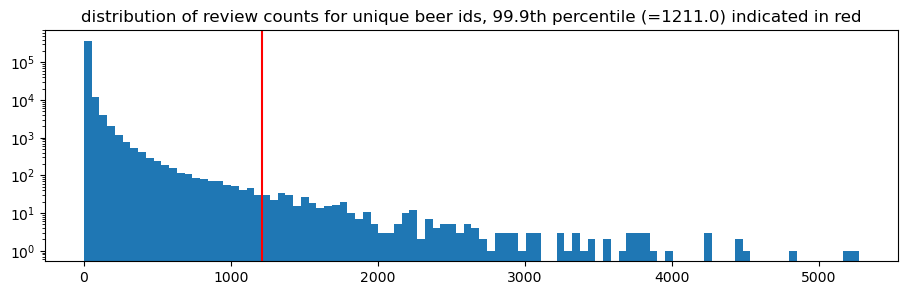

In [8]:
data = [beer_review_counts[k] for k in beer_review_counts]

q = 99.9 # for memory 
p = np.percentile(data, q)
plt.figure(figsize=(11, 3))
plt.hist(data, bins=100)
plt.axvline(p, color="r")

plt.title(f"distribution of review counts for unique beer ids, {q}th percentile (={p}) indicated in red")
#plt.yscale("log")
plt.yscale("log")

In [9]:
beer_with_min_count = [beer_id for beer_id in beer_review_counts if beer_review_counts[beer_id] > p]
len(beer_with_min_count), len(beer_review_counts)

(396, 396690)

In [10]:
beer_reviews = {}

for review in iter_reviews("../data/RateBeer/reviews.txt"):
    beer_id = review["beer_id"]
    if beer_id in beer_with_min_count:
        beer_reviews.setdefault(beer_id, []).append(review)

sum(len(beer_reviews[k]) for k in beer_reviews)

100%|█████████████████████████████████████████████████| 7122074/7122074 [00:50<00:00, 142360.88it/s]


760422

In [11]:
my_beer_id = next(iter(beer_reviews))
pd.DataFrame(beer_reviews[my_beer_id]).head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Tiger Beer,3126,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Pale Lager,5.0,1500112800,lokis333,375455,3.0,6.0,4.0,7.0,12.0,3.2,Golden color with medium white foam. Aromas of...
1,Tiger Beer,3126,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Pale Lager,5.0,1500026400,sebsky,478504,3.0,2.0,2.0,3.0,6.0,1.6,"640 ml bottle @home,bb 31/05/2018.Golden,clear..."


### Extracting beer information from the reviews

In [12]:
# TODO extract more
REVIEW_COLUMNS = [
    'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating'
]

def aggregate_reviews(reviews):
    reviews = pd.DataFrame(reviews)
    return reviews[REVIEW_COLUMNS].mean()

aggregate_reviews(beer_reviews[my_beer_id])

appearance    2.579692
aroma         3.875964
palate        2.370823
taste         4.231362
overall       8.327763
rating        2.138560
dtype: float64

In [13]:
rb_beers = pd.read_csv("../data/RateBeer/beers.csv")

if set(REVIEW_COLUMNS) & set(rb_beers.columns) != set():
    raise ValueError("review columns contain names already in the dataset, we would be overwriting data")

aggregated_reviews = []

for beer_id in beer_reviews:
    reviews = beer_reviews[beer_id]
    aggregated_data = aggregate_reviews(reviews)
    aggregated_data["beer_id"] = beer_id  # add the beer_id to match on
    aggregated_reviews.append(aggregated_data)

aggregated_reviews_df = pd.DataFrame(aggregated_reviews)

rb_beers = rb_beers.merge(aggregated_reviews_df, on="beer_id", how="inner")

print(rb_beers.shape)
rb_beers.head()

(396, 20)


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,appearance,aroma,palate,taste,overall,rating
0,3126,Tiger Beer,547,Singapore Brewery (Asia Pacific Breweries-Hein...,Pale Lager,1556,5.0,50.0,2.13,5.0,2.138560,NaN,0,NaN,2.579692,3.875964,2.370823,4.231362,8.327763,2.138560
1,730,Tsingtao,116,Tsingtao Brewery,Pale Lager,2031,3.0,42.0,2.03,4.8,2.045790,NaN,0,NaN,2.397834,3.712949,2.329394,4.077302,7.940423,2.045790
2,224,Dos Equis XX Ambar (Amber),46,FEMSA - Cuauhtémoc-Moctezuma (Heineken),Amber Lager/Vienna,1741,9.0,24.0,2.45,4.7,2.469500,NaN,0,NaN,3.049971,4.332567,2.647904,4.893165,9.771396,2.469500
3,225,Dos Equis XX Special Lager,46,FEMSA - Cuauhtémoc-Moctezuma (Heineken),Pale Lager,1518,4.0,46.0,2.08,4.2,2.098221,NaN,0,NaN,2.519763,3.681818,2.391304,4.187747,8.201581,2.098221
4,230,Sol (Mexico),46,FEMSA - Cuauhtémoc-Moctezuma (Heineken),Pale Lager,1241,1.0,10.0,1.68,4.5,1.705721,NaN,0,NaN,2.228042,3.019339,2.041096,3.355359,6.413376,1.705721


### Choosing the negative reviews

In [14]:
all_ratings = [review["rating"] for review in iter_reviews("../data/RateBeer/ratings.txt")]

100%|█████████████████████████████████████████████████| 7122074/7122074 [00:37<00:00, 188887.75it/s]


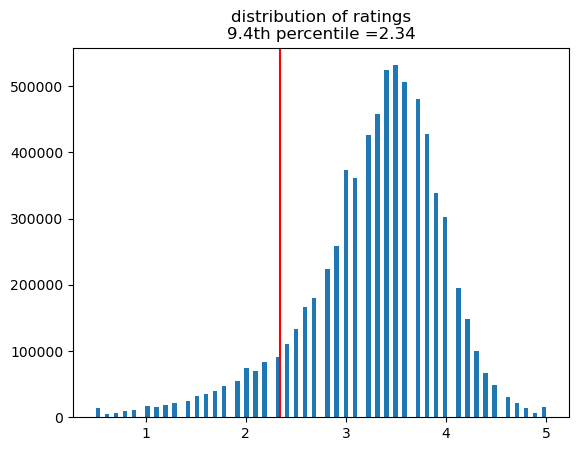

In [15]:
import matplotlib.pyplot as plt

counts, bins, _ = plt.hist(all_ratings, bins=100)

percentile = 10
percentiles_at_bins = np.cumsum(counts / counts.sum())
percentile_idx = np.argmin(np.abs(percentiles_at_bins - percentile / 100))
percentile_top_bin = bins[percentile_idx+1]

actual_percentile = percentiles_at_bins[percentile_idx] * 100
plt.title(f"distribution of ratings\n{actual_percentile:.1f}th percentile ={percentile_top_bin:.2f}")
plt.axvline(percentile_top_bin, color="r");

In [16]:
min_reviews = 10
best_beer_reviews, worst_beer_reviews = {}, {}

for beer_id in beer_reviews:
    best_reviews, worst_reviews = [], []

    for review in beer_reviews[beer_id]:
        rating = review["rating"]

        if rating <= percentile_top_bin:
            worst_reviews.append(review["text"])
        else:
            best_reviews.append(review["text"])

    if len(worst_reviews) > min_reviews and len(best_reviews) > min_reviews:
        best_beer_reviews[beer_id] = best_reviews
        worst_beer_reviews[beer_id] = worst_reviews

for i, beer_id in enumerate(worst_beer_reviews):
    print(f"{beer_id} went from {len(beer_reviews[beer_id])} total reviews to",
          f"{len(worst_beer_reviews[beer_id])} negative reviews")
    if i - 1 >= 15:
        break

3126 went from 1556 total reviews to 1032 negative reviews
730 went from 2031 total reviews to 1464 negative reviews
224 went from 1741 total reviews to 722 negative reviews
225 went from 1518 total reviews to 1038 negative reviews
230 went from 1241 total reviews to 1062 negative reviews
226 went from 1250 total reviews to 1024 negative reviews
742 went from 3650 total reviews to 2951 negative reviews
744 went from 1311 total reviews to 965 negative reviews
745 went from 2246 total reviews to 509 negative reviews
746 went from 1382 total reviews to 944 negative reviews
237 went from 1403 total reviews to 969 negative reviews
8820 went from 1650 total reviews to 47 negative reviews
1929 went from 1677 total reviews to 12 negative reviews
13558 went from 1550 total reviews to 55 negative reviews
1094 went from 3052 total reviews to 37 negative reviews
1921 went from 2506 total reviews to 24 negative reviews
1926 went from 2845 total reviews to 24 negative reviews


In [17]:
reviews_count_data = pd.DataFrame(
    [(beer_id, len(beer_reviews[beer_id]), len(worst_beer_reviews[beer_id])) for beer_id in worst_beer_reviews],
    columns=["beer_id", "total_reviews", "bad_reviews"]
)

rb_beers = rb_beers.merge(reviews_count_data, on="beer_id", how="inner")

### Identifying the main criticism(s)

In [18]:
rb_brewery_locations = pd.read_csv("../data/RateBeer/breweries.csv")[["id", "location"]]
rb_brewery_locations = rb_brewery_locations.rename(columns={"location": "brewery_location"})
rb_brewery_locations.head()

,id,brewery_location
0,3198,Gabon
1,13538,Northern Ireland
2,22304,Northern Ireland
3,22818,Northern Ireland
4,24297,Northern Ireland


In [19]:
rb_beers = rb_beers.merge(rb_brewery_locations, left_on="brewery_id", right_on="id", how="inner")

In [20]:
rb_beers.head(2)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,...,appearance,aroma,palate,taste,overall,rating,total_reviews,bad_reviews,id,brewery_location
0,3126,Tiger Beer,547,Singapore Brewery (Asia Pacific Breweries-Hein...,Pale Lager,1556,5.0,50.0,2.13,5.0,...,2.579692,3.875964,2.370823,4.231362,8.327763,2.13856,1556,1032,547,Singapore
1,730,Tsingtao,116,Tsingtao Brewery,Pale Lager,2031,3.0,42.0,2.03,4.8,...,2.397834,3.712949,2.329394,4.077302,7.940423,2.04579,2031,1464,116,China


In [21]:
KEEP_COLS = [
    "beer_id", "style", 'abv', 'avg_computed', "total_reviews", "bad_reviews", "brewery_location"
] + REVIEW_COLUMNS

rb_beers[KEEP_COLS].head()

,beer_id,style,abv,avg_computed,total_reviews,bad_reviews,brewery_location,appearance,aroma,palate,taste,overall,rating
0,3126,Pale Lager,5.0,2.138560,1556,1032,Singapore,2.579692,3.875964,2.370823,4.231362,8.327763,2.138560
1,730,Pale Lager,4.8,2.045790,2031,1464,China,2.397834,3.712949,2.329394,4.077302,7.940423,2.045790
2,224,Amber Lager/Vienna,4.7,2.469500,1741,722,Mexico,3.049971,4.332567,2.647904,4.893165,9.771396,2.469500
3,225,Pale Lager,4.2,2.098221,1518,1038,Mexico,2.519763,3.681818,2.391304,4.187747,8.201581,2.098221
4,230,Pale Lager,4.5,1.705721,1241,1062,Mexico,2.228042,3.019339,2.041096,3.355359,6.413376,1.705721


In [22]:
rb_beers = rb_beers[KEEP_COLS]

In [23]:
worst_beer_reviews[next(iter(worst_beer_reviews))][:5]

['640 ml bottle @home,bb 31/05/2018.Golden,clear. Faint hay aroma.Taste is malt-ish water. Fizzy. ',
 'Clear golden color with white head. Aroma of malt, grain and hay. Taste is little sweet with light bitter finish. Notes of citrus. Normal lager beer.  ',
 '330ml bottle. Clear yellow, thinnest white cap. Nose is malt, honey, corn, grass. Flavors follow with a touch of skunk on the sweetish finish. Ok. ',
 'Bottle in pai, thailand. Common lager, could be from anywhere, refreshing, crispy. ',
 'Bottled as Tiger Asian Lager, from Total Wine, South Richmond. Pours clear pale golden with a large white head. Aroma is sweet corn and grass. Flavor is sweet grasses, grain, very bitter green leaves. Nothing Iâ\x80\x99d choose to drink again. ']

In [27]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#nltk.download("all")

# inspired by https://gist.github.com/4OH4/f727af7dfc0e6bb0f26d2ea41d89ee55
class Lemmatizer:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def _wordnet_pos(self, word):
        """Map POS (part of speech) tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    def __call__(self, text):
        words = word_tokenize(text)
        return [self.lemmatizer.lemmatize(w, self._wordnet_pos(w)) for w in words]

Lemmatizer()("hey:; you are here")

['hey', ':', ';', 'you', 'be', 'here']

In [36]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from string import punctuation

LEMMATIZER = Lemmatizer()

STOP_WORDS = stopwords.words("english") + list(punctuation)
STOP_WORDS = [sw for sw in STOP_WORDS if sw not in ["no", "not"]] # don't remove negatives
STOP_WORDS_LEMMATIZED = LEMMATIZER(' '.join(STOP_WORDS))

def word_freq(corpus, lemmatize=False, ngram=1):
    if lemmatize:
        vectorizer = CountVectorizer(
            stop_words=STOP_WORDS_LEMMATIZED, ngram_range=(1, ngram),
            tokenizer=LEMMATIZER, token_pattern=None)
    else:
        vectorizer = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(1, ngram))

    X = vectorizer.fit_transform(corpus)

    word_counts = pd.DataFrame({
        "word": vectorizer.get_feature_names_out(),
        "freq": np.array(X.sum(axis=0))[0]
    })

    word_counts = word_counts[~word_counts["word"].isin(STOP_WORDS)]

    return word_counts

def top_negative_words(corpus_neg, corpus_pos, use_tfidf=False, lemmatize=False, ngram=1):
    if use_tfidf:
        all_reviews = corpus_neg + corpus_pos
        labels = ["negative"] * len(corpus_neg) + ["positive"] * len(corpus_pos)

        if lemmatize:
            tfidf_vectorizer = TfidfVectorizer(
                stop_words=STOP_WORDS_LEMMATIZED, ngram_range=(1, ngram),
                tokenizer=LEMMATIZER, token_pattern=None)
        else:
            tfidf_vectorizer = TfidfVectorizer(stop_words=STOP_WORDS, ngram_range=(1, ngram))
            

        tfidf_matrix = tfidf_vectorizer.fit_transform(all_reviews)
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
        tfidf_df["label"] = labels

        positive_tfidf = tfidf_df[tfidf_df["label"] == "positive"].drop(columns=["label"]).mean()
        negative_tfidf = tfidf_df[tfidf_df["label"] == "negative"].drop(columns=["label"]).mean()

        top_negative_words = pd.DataFrame({
            "avg_pos_score": positive_tfidf,
            "avg_neg_score": negative_tfidf,
            "score_diff": negative_tfidf - positive_tfidf
        }).sort_values(by="score_diff", ascending=False)

        return top_negative_words

    else: # use word frequencies
        freq_neg = word_freq(corpus_neg, lemmatize=lemmatize, ngram=ngram)
        freq_pos = word_freq(corpus_pos, lemmatize=lemmatize, ngram=ngram)

        combined = freq_neg.merge(freq_pos, on="word", how="outer", suffixes=("_neg", "_pos"))
        combined = combined.fillna(0)
        combined["freq_diff"] = combined["freq_neg"] - combined["freq_pos"]

        top_negative_words = combined.sort_values(by="freq_diff", ascending=False)
        return top_negative_words.set_index("word")

In [37]:
beer_id = next(iter(worst_beer_reviews))
corpus_best = best_beer_reviews[beer_id]
corpus_worst = worst_beer_reviews[beer_id]

print(f"top negative words for beer {beer_id} :")
top_negative_words(corpus_worst, corpus_best, use_tfidf=False, lemmatize=True, ngram=2).head(20)

top negative words for beer 3126 :


,freq_neg,freq_pos,freq_diff
word,,,
head,548.0,256.0,292.0
aroma,499.0,235.0,264.0
taste,482.0,223.0,259.0
white,384.0,173.0,211.0
bottle,375.0,164.0,211.0
pale,364.0,166.0,198.0
light,468.0,273.0,195.0
white head,311.0,129.0,182.0
not,399.0,222.0,177.0


In [43]:
n = 100

for i, beer_id in enumerate(worst_beer_reviews):
    if i == 0:
        continue

    if i - 1 >= n:
        break

    corpus_best = best_beer_reviews[beer_id]
    corpus_worst = worst_beer_reviews[beer_id]

    negative_words = top_negative_words(corpus_worst, corpus_best, use_tfidf=True, lemmatize=True, ngram=2)
    negative_words = list(negative_words.head(20).index)

    print(f"top negative words for beer {beer_id} : {negative_words}", end="\n\n")

top negative words for beer 730 : ['watery', 'no', 'bottle', 'water', 'pale', 'head', 'bland', 'weak', 'corn', 'almost', 'white head', 'head aroma', 'yellow', 'not good', 'white', 'almost no', 'aroma', 'pale yellow', 'no head', 'thin']

top negative words for beer 224 : ['corn', 'watery', 'no', 'aroma', 'not good', 'taste like', 'sweet', 'metallic', 'weak', 'nothing', 'small', 'skunky', 'malt', 'water', 'boring', 'like', 'bottle pours', 'bottle', 'caramel', 'still']

top negative words for beer 225 : ['watery', 'yellow', 'aroma', 'no', 'head', 'corn', 'water', 'white', 'white head', 'pours', 'malt', 'bottle', 'clear', 'pale', 'flavor', 'weak', 'no head', 'small', 'boring', 'not much']

top negative words for beer 230 : ['no', 'water', 'watery', 'yellow', 'head', 'aroma', 'corn', 'pale', 'small', 'little', 'white head', 'bland', 'boring', 'white', 'bad', 'pale yellow', 'flavour', 'metallic', 'fizzy', 'bottle']

top negative words for beer 226 : ['corn', 'water', 'aroma', 'taste', 'water